In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

import os
from tempfile import TemporaryDirectory

In [2]:
batch_size = 8
number_of_epochs = 2

# Load Dataset and split in train and test

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_Eurosat = torchvision.datasets.EuroSAT(root='./data',
                                        download=True, transform=transform)

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
           'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

classes_len = len(classes)

In [4]:
generator = torch.Generator().manual_seed(42)
eurosat_train, eurosat_val, eurosat_test = torch.utils.data.random_split(dataset_Eurosat, [0.7, 0.15, 0.15], generator)

trainloader = torch.utils.data.DataLoader(eurosat_train, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(eurosat_val, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(eurosat_test, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Print some example images and dataset size

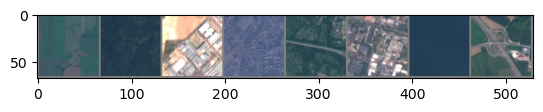

Pasture Forest Industrial Residential Highway Industrial SeaLake Highway


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
train_len = len(eurosat_train)
val_len = len(eurosat_val)
test_len = len(eurosat_test)
total_len = train_len + val_len + test_len

print(f'Size of Dataset: {total_len}\nTrain size: {train_len} ({train_len/total_len * 100}%)\nValidation size: {val_len} ({val_len/total_len * 100}%)\nTest size: {test_len} ({test_len/total_len * 100}%)\n')

print(f'Image size is {images.shape[2]}x{images.shape[3]} with {images.shape[1]} channels')

Size of Dataset: 27000
Train size: 18900 (70.0%)
Validation size: 4050 (15.0%)
Test size: 4050 (15.0%)

Image size is 64x64 with 3 channels


# Train and test methods

In [7]:
def train(epoch, net, optimizer, criterion, device):
    start_time = time.time()
    
    net.to(device)
    
    for epoch in range(epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 400 == 399:    # print every 400 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.3f}')
                
                running_loss = 0.0

    end_time = time.time() - start_time
    print('Finished Training')
    return net, end_time

In [8]:
dataloaders = {'train': trainloader, 'val': valloader}
dataset_sizes = {'train': train_len, 'val': val_len}

def train_transfer(num_epochs, net, optimizer, criterion, scheduler, device):
    since = time.time()

    net.to(device)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(net.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    net.train()  # Set model to training mode
                else:
                    net.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = net(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(net.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        net.load_state_dict(torch.load(best_model_params_path))
    return net, time_elapsed

In [9]:
def test_topk(net, device, topk=3):
    net.to(device)
    
    false_images = []
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.topk(outputs, topk)
            
            mask = [l in p for l, p in zip(labels, predicted)]
            mask = np.array(mask)
            if any(value == False for value in mask):
                false_images.append([[im, l] for im, l, mask in zip(images, labels, mask) if not mask])
            #false_images_labels.append(labels[~mask])
                        
            total += labels.size(0)
            correct += sum(mask)

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the {test_len} test images (Top {topk}): {accuracy} %')

    return accuracy, false_images

## save and load checkpoints

In [10]:
checkpoint_dir = './checkpoints/koph/'

def save_checkpoint(net, train_time, acc_1, acc_3, filename):
    checkpoint_path = checkpoint_dir + filename
    torch.save({
                'model_state_dict': net.state_dict(),
                'acc_1': acc_1,
                'acc_3': acc_3,
                'train_time': train_time,
            }, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

def load_checkpoint(net, filename):
    checkpoint_path = checkpoint_dir + filename
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    train_time = checkpoint['train_time']
    acc_1 = checkpoint['acc_1']
    acc_3 = checkpoint['acc_3']
    
    return net, train_time, acc_1, acc_3

# Load flags

In [11]:
cnn_load_checkpoint = False

resnet_pretrained_load_checkpoint = False
resnet_fixed_load_checkpoint = False
resnet_fine_load_checkpoint = False

effnet_pretrained_load_checkpoint = False
effnet_fixed_load_checkpoint = False
effnet_fine_load_checkpoint = False

# CNN with BN

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, classes_len)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [13]:
import torch.optim as optim

net = CNNet()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
cnn_time = 0

if not cnn_load_checkpoint:

    net, cnn_time = train(number_of_epochs, net, optimizer_cnn, criterion_cnn, device)

[1,   400] loss: 1.598
[1,   800] loss: 1.303
[1,  1200] loss: 1.191
[1,  1600] loss: 1.044
[1,  2000] loss: 0.957
[2,   400] loss: 0.845
[2,   800] loss: 0.798
[2,  1200] loss: 0.794
[2,  1600] loss: 0.738
[2,  2000] loss: 0.722
Finished Training


In [15]:
cnn_time

70.31147313117981

In [16]:
cnn_acc_1 = 0
cnn_acc_3 = 0

if not cnn_load_checkpoint:
    cnn_acc_1, _ = test_topk(net, device, 1)
    cnn_acc_3, _ = test_topk(net, device)

Accuracy of the network on the 4050 test images (Top 1): 75 %
Accuracy of the network on the 4050 test images (Top 3): 95 %


In [17]:
if cnn_load_checkpoint:
    net, cnn_time, cnn_acc_1, cnn_acc_3 = load_checkpoint(net, 'cnn.chk')

In [18]:
save_checkpoint(net, cnn_time, cnn_acc_1, cnn_acc_3, 'cnn.chk')

Checkpoint saved at ./checkpoints/koph/cnn.chk


# ResNet18

In [19]:
resnet = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, classes_len)

In [20]:
resnet_pretrained_acc_1 = 0
resnet_pretrained_acc_3 = 0

if not resnet_pretrained_load_checkpoint:
    resnet_pretrained_acc_1, _ = test_topk(resnet, device, 1)
    resnet_pretrained_acc_3, _ = test_topk(resnet, device)
else:
    _, _, resnet_pretrained_acc_1, resnet_pretrained_acc_3 = load_checkpoint(resnet, 'resnet_pretrained.chk')

Accuracy of the network on the 4050 test images (Top 1): 12 %
Accuracy of the network on the 4050 test images (Top 3): 33 %


In [21]:
save_checkpoint(resnet, 0, resnet_pretrained_acc_1, resnet_pretrained_acc_3, 'resnet_pretrained.chk')

Checkpoint saved at ./checkpoints/koph/resnet_pretrained.chk


## Fixed Feature Extractor

In [22]:
from torch.optim import lr_scheduler

In [23]:
resnet_fixed = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in resnet_fixed.parameters():
    param.requires_grad = False

num_ftrs = resnet_fixed.fc.in_features
resnet_fixed.fc = nn.Linear(num_ftrs, classes_len)


criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(resnet_fixed.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

In [24]:
resnet_fixed_time = 0

if not resnet_fixed_load_checkpoint:

    resnet_fixed, resnet_fixed_time = train_transfer(number_of_epochs, resnet_fixed, optimizer_resnet, criterion_resnet,
                            exp_lr_scheduler_resnet, device)

Epoch 0/1
----------
train Loss: 1.0193 Acc: 0.6737
val Loss: 0.7430 Acc: 0.7941

Epoch 1/1
----------
train Loss: 0.9180 Acc: 0.7088
val Loss: 0.6087 Acc: 0.8138

Training complete in 1m 5s
Best val Acc: 0.813827


In [25]:
resnet_fixed_acc_1 = 0
resnet_fixed_acc_3 = 0

if not resnet_fixed_load_checkpoint:
    resnet_fixed_acc_1, _ = test_topk(resnet_fixed, device, 1)
    resnet_fixed_acc_3, _ = test_topk(resnet_fixed, device)

Accuracy of the network on the 4050 test images (Top 1): 81 %
Accuracy of the network on the 4050 test images (Top 3): 96 %


In [26]:
if resnet_fixed_load_checkpoint:
    resnet_fixed, resnet_fixed_time, resnet_fixed_acc_1, resnet_fixed_acc_3 = load_checkpoint(resnet_fixed, 'resnet_fixed.chk')

In [27]:
save_checkpoint(resnet_fixed, resnet_fixed_time, resnet_fixed_acc_1, resnet_fixed_acc_3, 'resnet_fixed.chk')

Checkpoint saved at ./checkpoints/koph/resnet_fixed.chk


## Finetuning

In [28]:
resnet_fine = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = resnet_fine.fc.in_features
resnet_fine.fc = nn.Linear(num_ftrs, classes_len)


criterion_resnet_fine = nn.CrossEntropyLoss()
optimizer_resnet_fine = optim.SGD(resnet_fine.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_resnet_fine = lr_scheduler.StepLR(optimizer_resnet_fine, step_size=7, gamma=0.1)

In [29]:
resnet_fine_time = 0

if not resnet_fine_load_checkpoint:

    resnet_fine, resnet_fine_time = train_transfer(number_of_epochs, resnet_fine, optimizer_resnet_fine, criterion_resnet_fine,
                            exp_lr_scheduler_resnet_fine, device)

Epoch 0/1
----------
train Loss: 0.9982 Acc: 0.6742
val Loss: 0.6470 Acc: 0.8037

Epoch 1/1
----------
train Loss: 0.8976 Acc: 0.7124
val Loss: 0.7134 Acc: 0.7946

Training complete in 1m 37s
Best val Acc: 0.803704


In [30]:
resnet_fine_acc_1 = 0
resnet_fine_acc_3 = 0

if not resnet_fine_load_checkpoint:
    resnet_fine_acc_1, _ = test_topk(resnet_fine, device, 1)
    resnet_fine_acc_3, _ = test_topk(resnet_fine, device)

Accuracy of the network on the 4050 test images (Top 1): 81 %
Accuracy of the network on the 4050 test images (Top 3): 96 %


In [31]:
if resnet_fine_load_checkpoint:
    resnet_fine, resnet_fine_time, resnet_fine_acc_1, resnet_fine_acc_3 = load_checkpoint(resnet_fine, 'resnet_fine.chk')

In [32]:
save_checkpoint(resnet_fine, resnet_fine_time, resnet_fine_acc_1, resnet_fine_acc_3, 'resnet_fine.chk')

Checkpoint saved at ./checkpoints/koph/resnet_fine.chk


# EfficientNet_B5

In [33]:
effnet = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')

num_ftrs = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(num_ftrs, classes_len, bias=True)

In [34]:
effnet_pretrained_acc_1 = 0
effnet_pretrained_acc_3 = 0

if not effnet_pretrained_load_checkpoint:
    effnet_pretrained_acc_1, _ = test_topk(effnet, device, 1)
    effnet_pretrained_acc_3, _ = test_topk(effnet, device)
else:
    _, _, effnet_pretrained_acc_1, effnet_pretrained_acc_3 = load_checkpoint(effnet, 'effnet_pretrained.chk')

Accuracy of the network on the 4050 test images (Top 1): 10 %
Accuracy of the network on the 4050 test images (Top 3): 30 %


In [35]:
save_checkpoint(effnet, 0, effnet_pretrained_acc_1, effnet_pretrained_acc_3, 'effnet_pretrained.chk')

Checkpoint saved at ./checkpoints/koph/effnet_pretrained.chk


## Fixed Feature Extractor

In [36]:
effnet_fixed = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')

for param in effnet_fixed.parameters():
    param.requires_grad = False

num_ftrs = effnet_fixed.classifier[1].in_features
effnet_fixed.classifier[1] = nn.Linear(num_ftrs, classes_len, bias=True)


criterion_effnet_fixed = nn.CrossEntropyLoss()
optimizer_effnet_fixed = optim.SGD(effnet_fixed.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_effnet_fixed = lr_scheduler.StepLR(optimizer_effnet_fixed, step_size=7, gamma=0.1)

In [37]:
effnet_fixed_time = 0

if not effnet_fixed_load_checkpoint:
    effnet_fixed, effnet_fixed_time = train_transfer(number_of_epochs, effnet_fixed, optimizer_effnet_fixed, criterion_effnet_fixed,
                            exp_lr_scheduler_effnet_fixed, device)

Epoch 0/1
----------
train Loss: 1.4881 Acc: 0.4953
val Loss: 1.5178 Acc: 0.5252

Epoch 1/1
----------
train Loss: 1.3692 Acc: 0.5302
val Loss: 1.4621 Acc: 0.5358

Training complete in 4m 15s
Best val Acc: 0.535802


In [38]:
effnet_fixed_acc_1 = 0
effnet_fixed_acc_3 = 0

if not effnet_fixed_load_checkpoint:
    effnet_fixed_acc_1, _ = test_topk(effnet_fixed, device, 1)
    effnet_fixed_acc_3, _ = test_topk(effnet_fixed, device)

Accuracy of the network on the 4050 test images (Top 1): 52 %
Accuracy of the network on the 4050 test images (Top 3): 79 %


In [39]:
if effnet_fixed_load_checkpoint:
    effnet_fixed, effnet_fixed_time, effnet_fixed_acc_1, effnet_fixed_acc_3 = load_checkpoint(effnet_fixed, 'effnet_fixed.chk')

In [40]:
save_checkpoint(effnet_fixed, effnet_fixed_time, effnet_fixed_acc_1, effnet_fixed_acc_3, 'effnet_fixed.chk')

Checkpoint saved at ./checkpoints/koph/effnet_fixed.chk


## Finetuning

In [41]:
effnet_fine = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')

num_ftrs = effnet_fine.classifier[1].in_features
effnet_fine.classifier[1] = nn.Linear(num_ftrs, classes_len, bias=True)


criterion_effnet_fine = nn.CrossEntropyLoss()
optimizer_effnet_fine = optim.SGD(effnet_fine.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_effnet_fine = lr_scheduler.StepLR(optimizer_effnet_fine, step_size=7, gamma=0.1)

In [42]:
effnet_fine_time = 0

if not effnet_fine_load_checkpoint:

    effnet_fine, effnet_fine_time = train_transfer(number_of_epochs, effnet_fine, optimizer_effnet_fine, criterion_effnet_fine,
                            exp_lr_scheduler_effnet_fine, device)

Epoch 0/1
----------
train Loss: 1.4952 Acc: 0.4885
val Loss: 1.5183 Acc: 0.5301

Epoch 1/1
----------
train Loss: 1.3644 Acc: 0.5328
val Loss: 1.4657 Acc: 0.5425

Training complete in 8m 58s
Best val Acc: 0.542469


In [43]:
effnet_fine_acc_1 = 0
effnet_fine_acc_3 = 0

if not effnet_fine_load_checkpoint:
    effnet_fine_acc_1, _ = test_topk(effnet_fine, device, 1)
    effnet_fine_acc_3, _ = test_topk(effnet_fine, device)

Accuracy of the network on the 4050 test images (Top 1): 51 %
Accuracy of the network on the 4050 test images (Top 3): 79 %


In [44]:
if effnet_fine_load_checkpoint:
    effnet_fine, effnet_fine_time, effnet_fine_acc_1, effnet_fine_acc_3 = load_checkpoint(effnet_fine, 'effnet_fine.chk')

In [45]:
save_checkpoint(effnet_fine, effnet_fine_time, effnet_fine_acc_1, effnet_fine_acc_3, 'effnet_fine.chk')

Checkpoint saved at ./checkpoints/koph/effnet_fine.chk


# Results

In [46]:
print('CNN')
print('-' * 10)
print(f'Training Time: {cnn_time}')
print(f'Accuracy (Top 1): {cnn_acc_1}%')
print(f'Accuracy (Top 3): {cnn_acc_3}%')
print()

print('Resnet18 without training')
print('-' * 10)
print(f'Training Time: ---')
print(f'Accuracy (Top 1): {resnet_pretrained_acc_1}%')
print(f'Accuracy (Top 3): {resnet_pretrained_acc_3}%')
print()
print('Resnet18 Fixed feature Extractor')
print('-' * 10)
print(f'Training Time: {resnet_fixed_time}')
print(f'Accuracy (Top 1): {resnet_fixed_acc_1}%')
print(f'Accuracy (Top 3): {resnet_fixed_acc_3}%')
print()
print('Resnet18 Finetuned')
print('-' * 10)
print(f'Training Time: {resnet_fine_time}')
print(f'Accuracy (Top 1): {resnet_fine_acc_1}%')
print(f'Accuracy (Top 3): {resnet_fine_acc_3}%')
print()

print('EfficientNet_B5 without training')
print('-' * 10)
print(f'Training Time: ---')
print(f'Accuracy (Top 1): {effnet_pretrained_acc_1}%')
print(f'Accuracy (Top 3): {effnet_pretrained_acc_3}%')
print()
print('EfficientNet_B5 Fixed feature Extractor')
print('-' * 10)
print(f'Training Time: {effnet_fixed_time}')
print(f'Accuracy (Top 1): {effnet_fixed_acc_1}%')
print(f'Accuracy (Top 3): {effnet_fixed_acc_3}%')
print()
print('EfficientNet_B5 Finetuned')
print('-' * 10)
print(f'Training Time: {effnet_fine_time}')
print(f'Accuracy (Top 1): {effnet_fine_acc_1}%')
print(f'Accuracy (Top 3): {effnet_fine_acc_3}%')
print()

CNN
----------
Training Time: 70.31147313117981
Accuracy (Top 1): 75%
Accuracy (Top 3): 95%

Resnet18 without training
----------
Training Time: ---
Accuracy (Top 1): 12%
Accuracy (Top 3): 33%

Resnet18 Fixed feature Extractor
----------
Training Time: 64.78106188774109
Accuracy (Top 1): 81%
Accuracy (Top 3): 96%

Resnet18 Finetuned
----------
Training Time: 97.14392852783203
Accuracy (Top 1): 81%
Accuracy (Top 3): 96%

EfficientNet_B5 without training
----------
Training Time: ---
Accuracy (Top 1): 10%
Accuracy (Top 3): 30%

EfficientNet_B5 Fixed feature Extractor
----------
Training Time: 255.08835434913635
Accuracy (Top 1): 52%
Accuracy (Top 3): 79%

EfficientNet_B5 Finetuned
----------
Training Time: 537.8268935680389
Accuracy (Top 1): 51%
Accuracy (Top 3): 79%

